In [1]:
cd /workspace

/workspace


In [2]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib.pyplot import rc_context
import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir='./figures/SC/'
sc.settings.set_figure_params(dpi=100, dpi_save=300,fontsize=12, frameon=False, facecolor='white', format='png', color_map='Reds')



In [3]:
results_file = 'data/multispecies_RATclust.h5ad'  # the file that will store the analysis results
pp_file = 'data/multispecies_RATpp.h5ad'


In [4]:
adata1 = sc.read_10x_mtx('./data/mtxmultispecies/rat11_1a/',var_names='gene_symbols', cache=True)
adata2 = sc.read_10x_mtx('./data/mtxmultispecies/rat11_2a/',var_names='gene_symbols',cache=True)
adata3 = sc.read_10x_mtx('./data/mtxmultispecies/rat11_2b/',var_names='gene_symbols',cache=True)
adata4 = sc.read_10x_mtx('./data/mtxmultispecies/rat39_3b/',var_names='gene_symbols',cache=True)
adata5 = sc.read_10x_mtx('./data/mtxmultispecies/merged_dups/', var_names='gene_symbols',cache=True)

... reading from cache file cache/data-mtxmultispecies-rat11_1a-matrix.h5ad
... reading from cache file cache/data-mtxmultispecies-rat11_2a-matrix.h5ad
... reading from cache file cache/data-mtxmultispecies-rat11_2b-matrix.h5ad
... reading from cache file cache/data-mtxmultispecies-rat39_3b-matrix.h5ad
... reading from cache file cache/data-mtxmultispecies-merged_dups-matrix.h5ad


In [5]:
adata1

AnnData object with n_obs × n_vars = 1346 × 66425
    var: 'gene_ids', 'feature_types'

In [6]:
sample_list=['rat11_1a','rat11_2a','rat11_2b','rat39_3b','rat39_3ac']

In [7]:
adata = adata1.concatenate(adata2, adata3, adata4, adata5, index_unique=None, batch_key="sample", batch_categories=sample_list) #Merge the data

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [8]:
adata.obs_names_make_unique()
adata.var_names_make_unique()
adata.var.index.is_unique
adata

AnnData object with n_obs × n_vars = 6361 × 66425
    obs: 'sample'
    var: 'gene_ids', 'feature_types'

In [9]:
set(adata.obs['sample'])

{'rat11_1a', 'rat11_2a', 'rat11_2b', 'rat39_3ac', 'rat39_3b'}

In [10]:
del adata1, adata2,adata3,adata4,adata5


In [11]:
sum(adata.var_names.str.startswith('GRCH38_MT-')), sum(adata.var_names.str.startswith('GRCH38')), sum(adata.var_names.str.startswith('Rnor6'))

(13, 33542, 32883)

normalizing counts per cell
    finished (0:00:00)


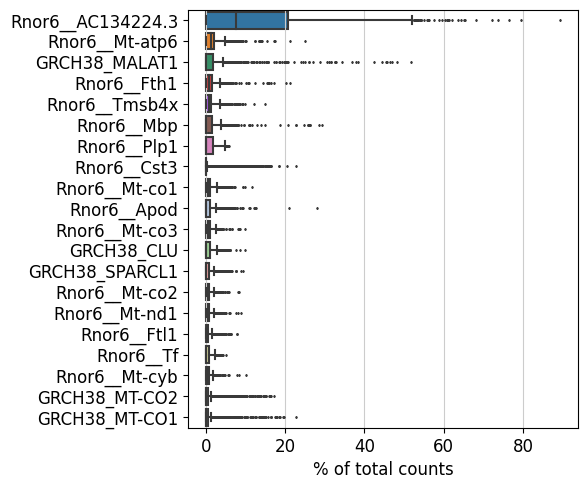

filtered out 66 cells that have less than 200 genes expressed
/opt/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
filtered out 34553 genes that are detected in less than 5 cells


AnnData object with n_obs × n_vars = 6295 × 31872
    obs: 'sample', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_human', 'pct_counts_human', 'total_counts_rat', 'pct_counts_rat'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'human', 'rat', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20,save='_Rat_SC' )
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=200)
sc.pp.filter_genes(adata, min_cells=5)
adata.var['mt'] = adata.var_names.str.startswith('GRCH38_MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['human'] = adata.var_names.str.startswith('GRCH38')  # annotate the group of mitochondrial genes as 'mt'
adata.var['rat'] = adata.var_names.str.startswith('Rnor6')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['human'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['rat'], percent_top=None, log1p=False, inplace=True)
adata

In [13]:
adata.obs['pct_counts_rat']

AAACCTGCAAGCGTAG-1    13.511560
AAACCTGCAGCCAGAA-1    97.843666
AAACCTGTCTGCAAGT-1    98.089523
AAACGGGCAACCGCCA-1    97.768761
AAAGATGAGGCATTGG-1    97.127831
                        ...    
GTCGGGTGTAAGCACG-1     2.941176
CGATGTAAGTACGATA-1    92.621353
TTAGTTCTCGCTGATA-1    91.252487
CCAATCCCAACACGCC-1     2.000000
ATCTGCCTCGTCGTTC-1     1.791045
Name: pct_counts_rat, Length: 6295, dtype: float32

... storing 'feature_types' as categorical


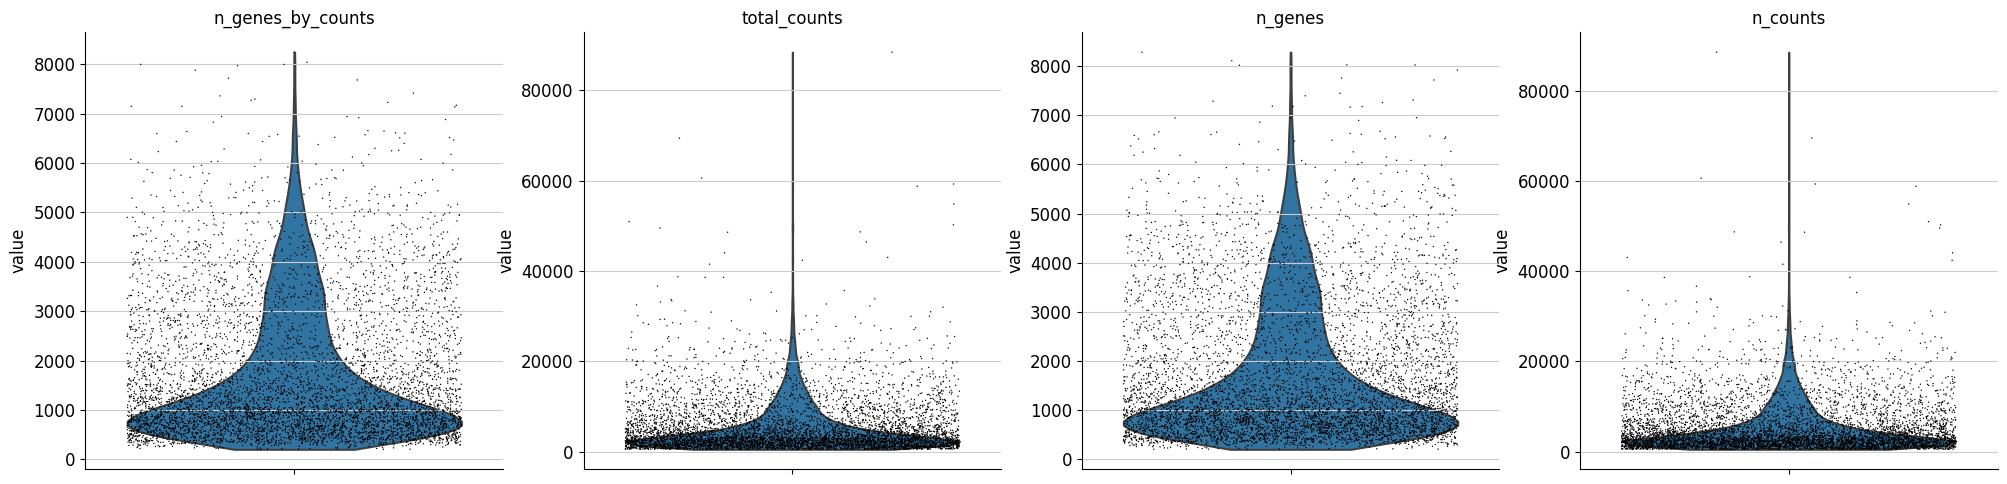

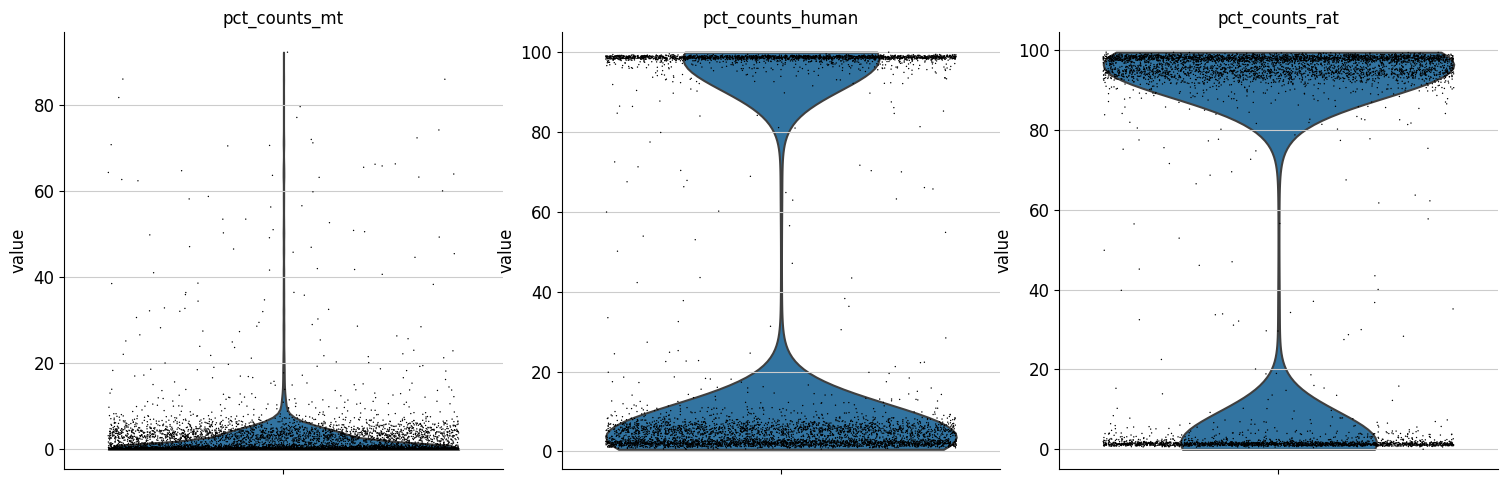

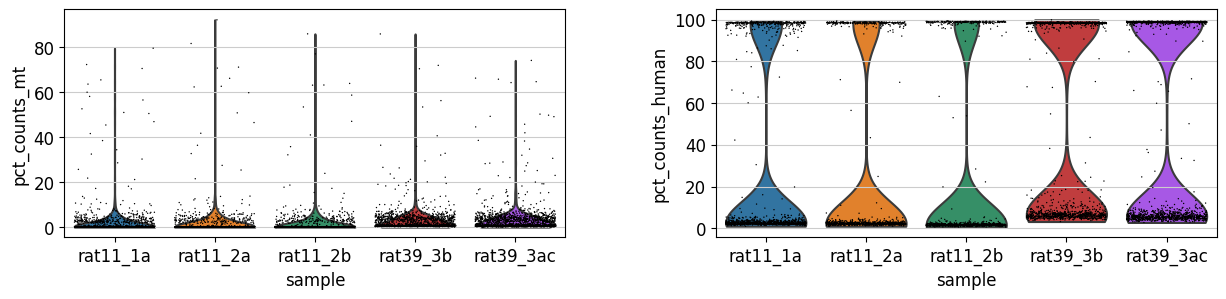

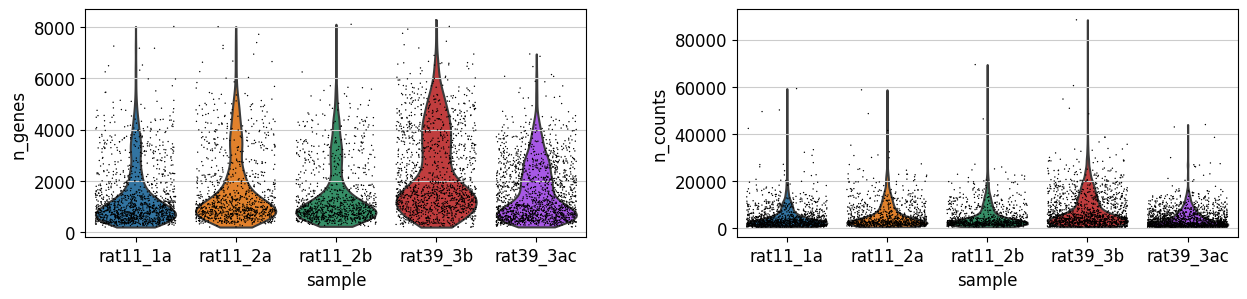

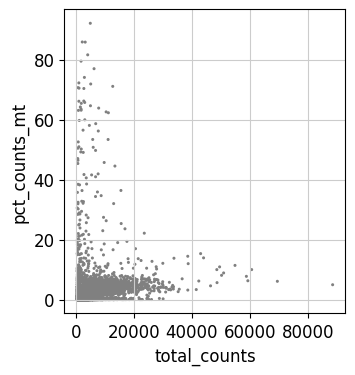

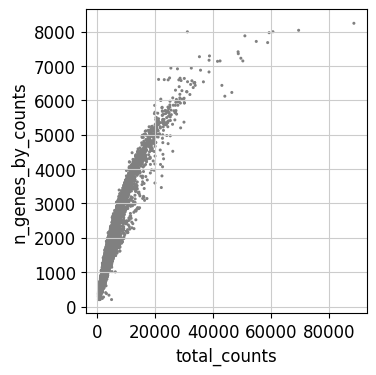

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts','total_counts', 'n_genes', 'n_counts'], jitter=0.4, multi_panel=True,ylabel='Counts',save='_nGenes_TotalCounts_Rat_SC')#l;abels do not work with multipanel
sc.pl.violin(adata,['pct_counts_mt', 'pct_counts_human', 'pct_counts_rat'], jitter=0.4, multi_panel=True,ylabel='Value %', save= '_pct_mit_human_rat_SC')
with rc_context({'figure.figsize': (6, 3)}):
    sc.pl.violin(adata,['pct_counts_mt','pct_counts_human'],groupby='sample',jitter=0.4, multi_panel=True, save= '_pcts_sample_SC')
    sc.pl.violin(adata,[ 'n_genes','n_counts'],groupby='sample',jitter=0.4, multi_panel=True, save= '_counts_sample_SC')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',save='_pctMT_total_countsRat_SC' ) #Cut under 10% mit
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',save='_total_genes_by_counts_Rat_SC') # cut under 5000 genes by counts

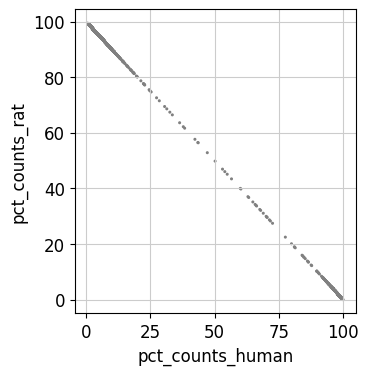

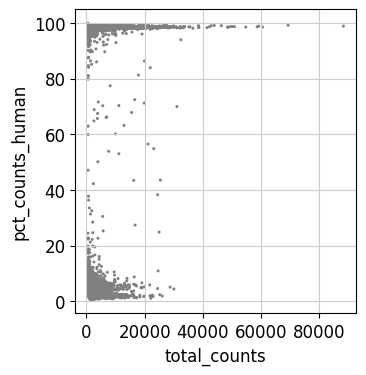

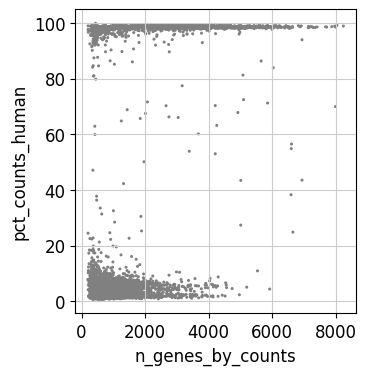

In [15]:
sc.pl.scatter(adata, x='pct_counts_human', y='pct_counts_rat',save='_pct_humanVRat_SC')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_human',save= '_total_pctHuman_SC')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_human', save='_gnesbyCounts_pctHuman_SC')

In [16]:
adata

AnnData object with n_obs × n_vars = 6295 × 31872
    obs: 'sample', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_human', 'pct_counts_human', 'total_counts_rat', 'pct_counts_rat'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'human', 'rat', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'

In [17]:
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

/opt/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [18]:
adata =adata[adata.obs.pct_counts_rat > 90, : ]

/opt/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [19]:
adata.obs['species'] = 'rat'

Trying to set attribute `.obs` of view, copying.


In [20]:
new_vars=[]
print(len(adata.var_names))
for gene in adata.var_names:
    new_varname = gene.split('_',1)[1]
    if new_varname.startswith('_'):
        new_vars.append(new_varname.split('_',1)[1])
    else :
        new_vars.append(new_varname)
print(len(new_vars))

31872
31872


In [21]:
adata.var['Orig_VarNames'] = adata.var_names
adata.var['New_VarNames'] = new_vars
adata.var_names = new_vars
adata

AnnData object with n_obs × n_vars = 3933 × 31872
    obs: 'sample', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_human', 'pct_counts_human', 'total_counts_rat', 'pct_counts_rat', 'species'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'human', 'rat', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Orig_VarNames', 'New_VarNames'
    uns: 'sample_colors'

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)


normalizing counts per cell
    finished (0:00:00)


In [23]:
sc.pp.log1p(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


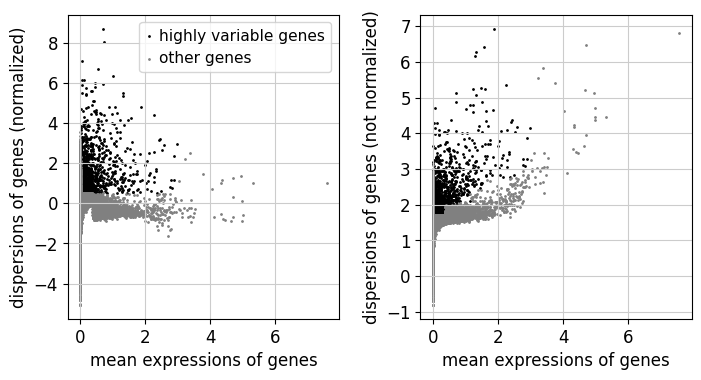

In [24]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata, save='_highly_variable_rat_SC')

In [25]:
adata.var_names_make_unique()
adata.raw = adata

In [26]:
adata = adata[:, adata.var.highly_variable]

In [27]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
/opt/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'species' as categorical
    finished (0:00:41)


In [28]:
sc.pp.scale(adata, max_value=10)

In [29]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
/opt/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    with n_comps=50
    finished (0:00:03)


In [30]:
sc.pl.pca_variance_ratio(adata, log=True, save='_PCA_rat_SC')

In [31]:
adata.write(results_file)
adatapp=adata.copy()

... storing 'New_VarNames' as categorical


In [32]:
#Compute neighborhood graph 
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)


In [33]:
sc.tl.leiden(adata, resolution= 0.22, key_added='leiden_0.22')
#sc.tl.louvain(adata, resolution= 0.3, key_added='louvain0.3')

running Leiden clustering
    finished: found 7 clusters and added
    'leiden_0.22', the cluster labels (adata.obs, categorical) (0:00:01)


In [34]:
# Embed it
#Prevent cluster rules vilations
#sc.tl.paga(adata,groups='louvain0.3')
#sc.pl.paga(adata)  # remove `plot=False` if you want to see the coarse-grained graph
#sc.tl.umap(adata, init_pos='paga')
sc.tl.paga(adata,groups='leiden_0.22')
sc.pl.paga(adata,save='_Paga_cpnectivities_SC')  # remove `plot=False` if you want to see the coarse-g
sc.tl.umap(adata, init_pos='paga', n_components=3, min_dist= 0.5)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)


In [35]:
adata

AnnData object with n_obs × n_vars = 3933 × 4242
    obs: 'sample', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_human', 'pct_counts_human', 'total_counts_rat', 'pct_counts_rat', 'species', 'leiden_0.22'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'human', 'rat', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Orig_VarNames', 'New_VarNames', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sample_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_0.22_sizes', 'leiden_0.22_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [36]:
adata.obsm['X_umap']#Its not computing the 3rd dimension

array([[13.664084 ,  8.314881 ],
       [12.322263 , 10.106547 ],
       [11.701462 , 12.189684 ],
       ...,
       [10.030923 ,  4.932178 ],
       [13.295582 ,  8.6195755],
       [ 9.921187 , 10.923833 ]], dtype=float32)

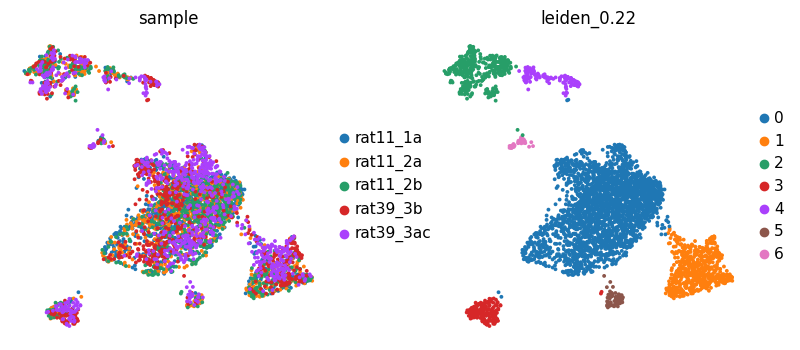

In [37]:
sc.pl.umap(adata, color=['sample', 'leiden_0.22'])

In [38]:
adata
adata.obs['clusters']=adata.obs['leiden_0.22']

In [39]:
markerdict={
'Neural progenitors' : ['NES', 'Sox2', 'Sox9'],
'Neurogenesis' : ['HES1','HES5','NEUROG2'],
'Neurons' : ['Map2','Gap43','NSG2','SNAP25','TH'],
'Astrocytes' : ['Gfap','Aqp4', 'Itih3','Slc1a3'],
'Microglia' : ['Cx3cr1','Lyn', 'Arhgap15'],
'Fibroblast' : ['Col18a1'],
'Oligodendrocytes' : ['Olig1','Olig2','PMP2','Sox10'],
'Endothelial' : ['Ebf1','ICAM1']}


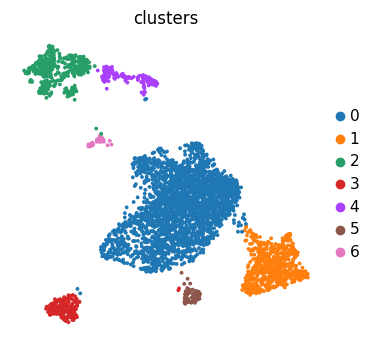

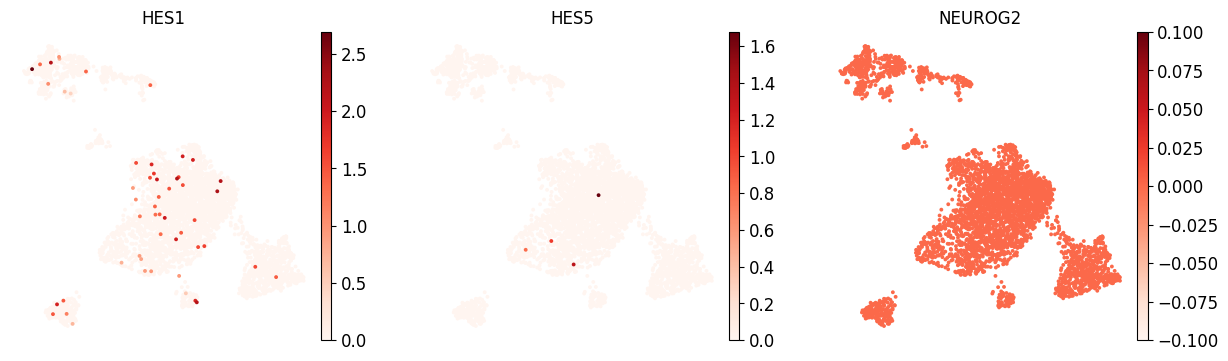

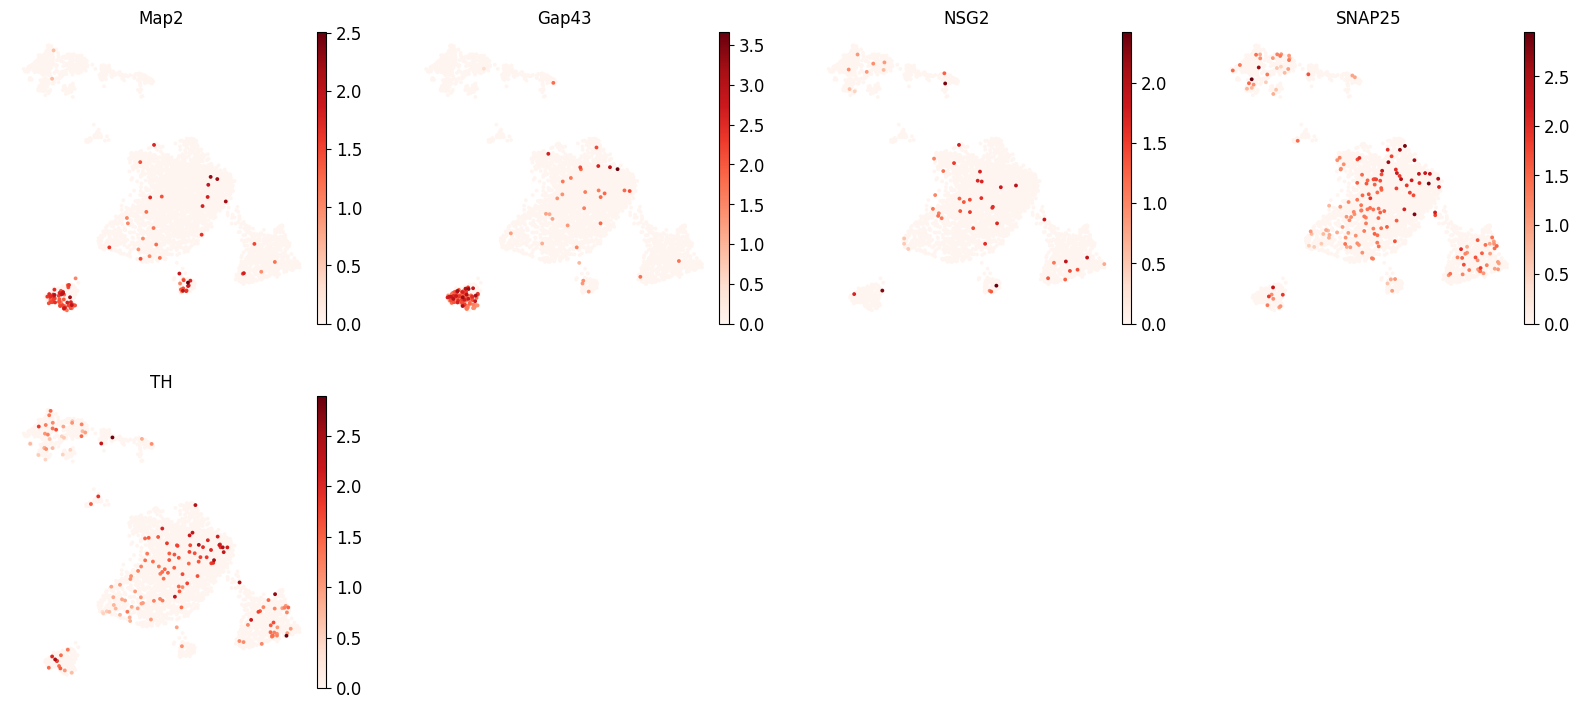

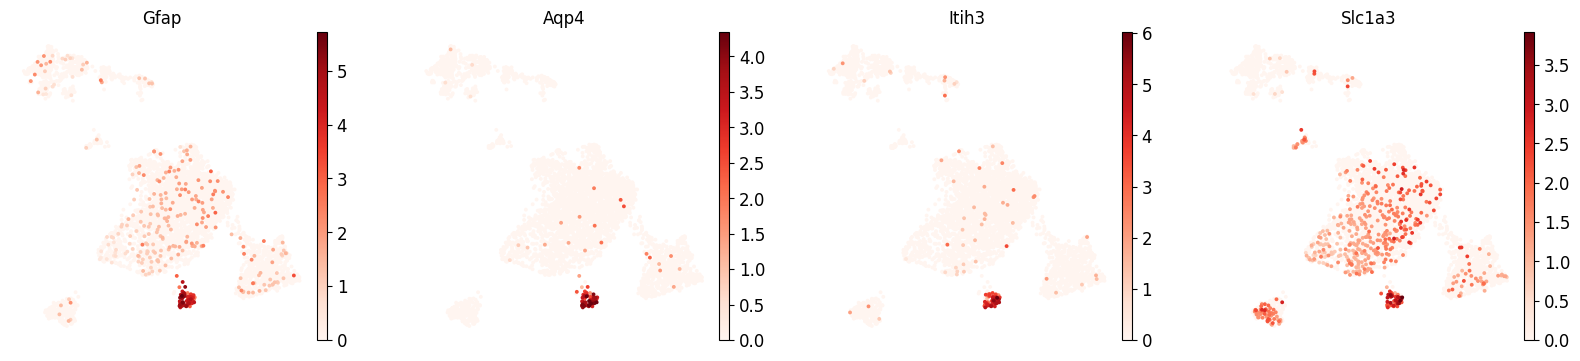

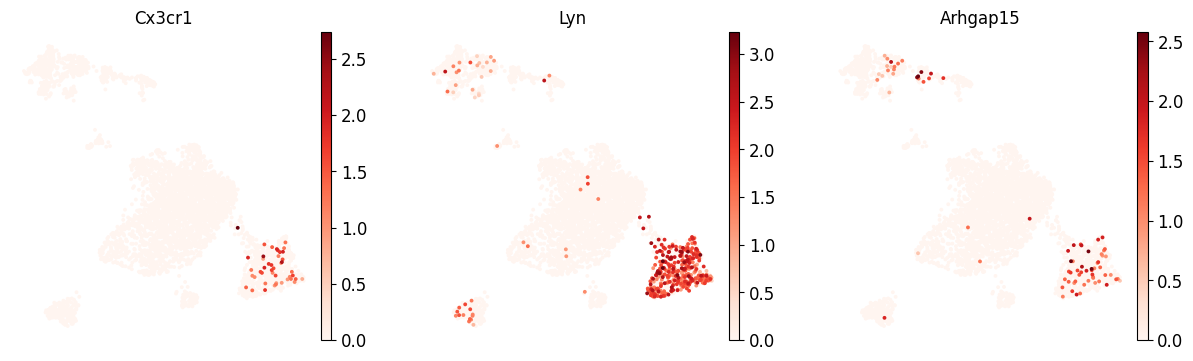

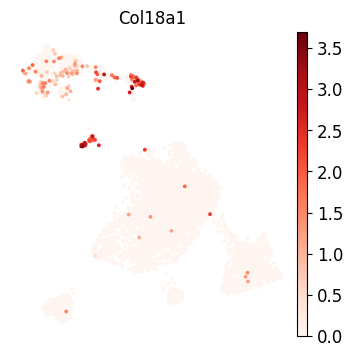

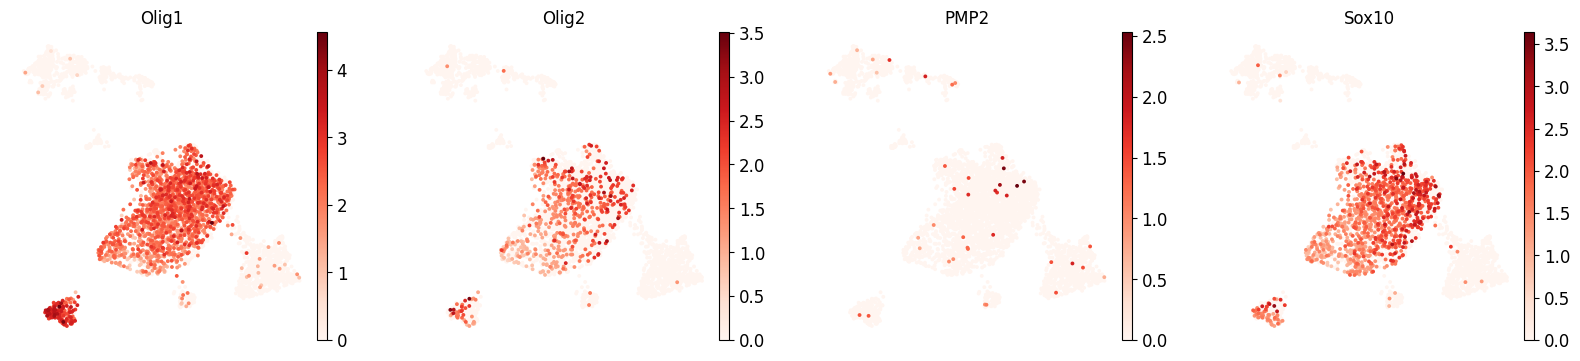

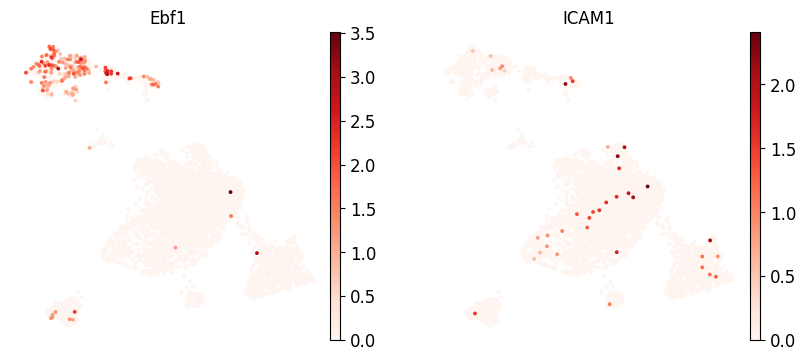

In [40]:
sc.pl.umap(adata, color = ['clusters'],save='_clust_0.20_Rat_SC')

for key in markerdict:
    strsave='_'+key+'_SC'
    sc.pl.umap(adata, color = markerdict[key],save = strsave)

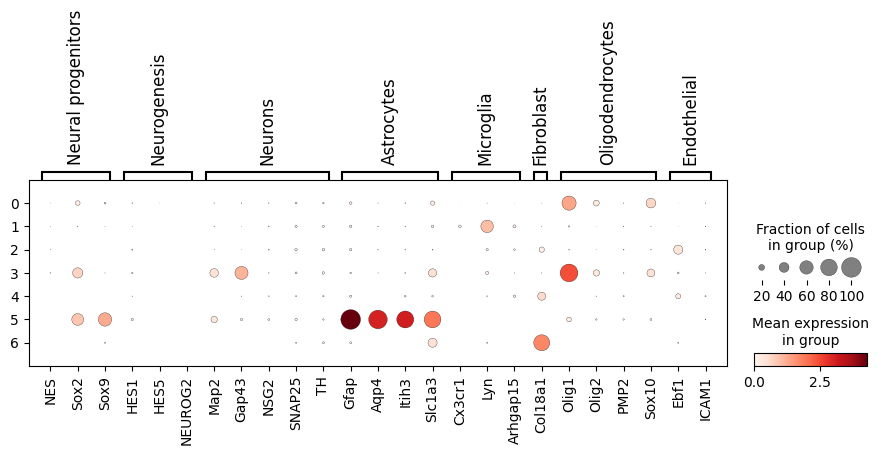

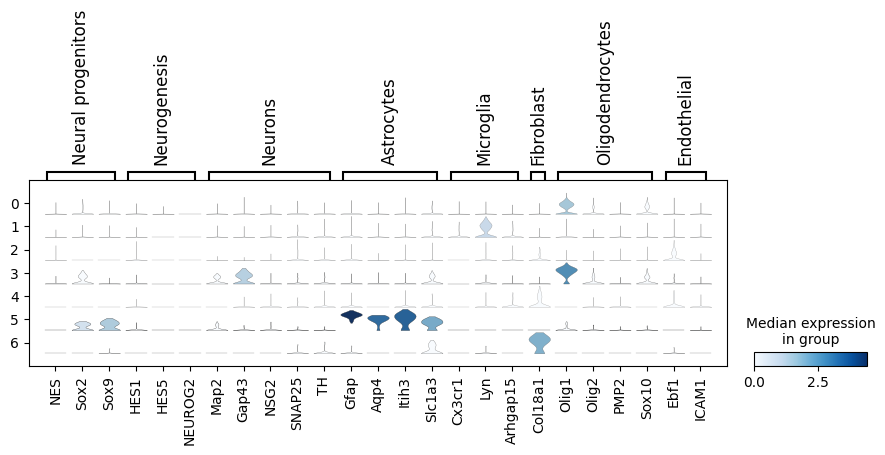

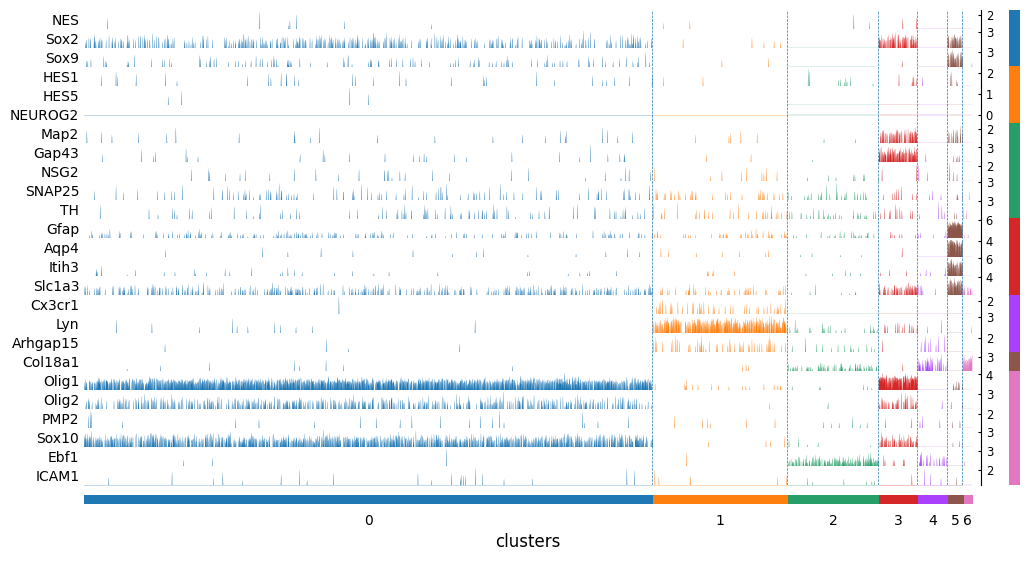

In [41]:
sc.pl.dotplot(adata, markerdict, 'clusters', dendrogram=False)
sc.pl.stacked_violin(adata, markerdict, 'clusters', dendrogram=False)
sc.pl.tracksplot(adata, markerdict, groupby='clusters', dendrogram=False)

In [42]:
sc.tl.rank_genes_groups(adata,'clusters', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


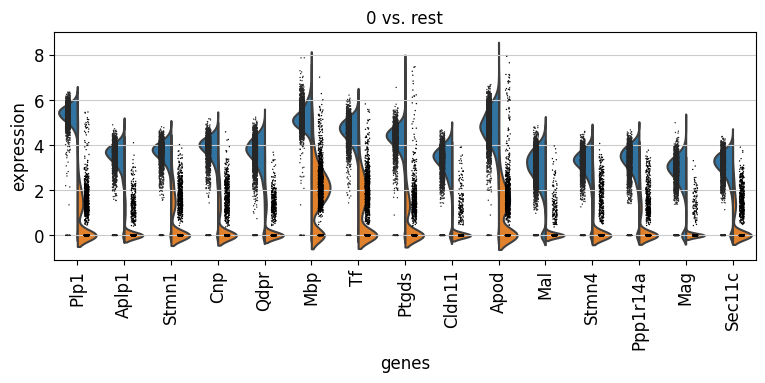

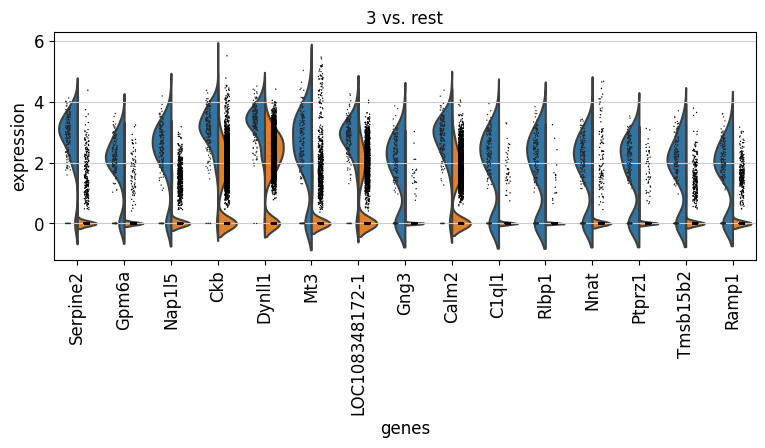

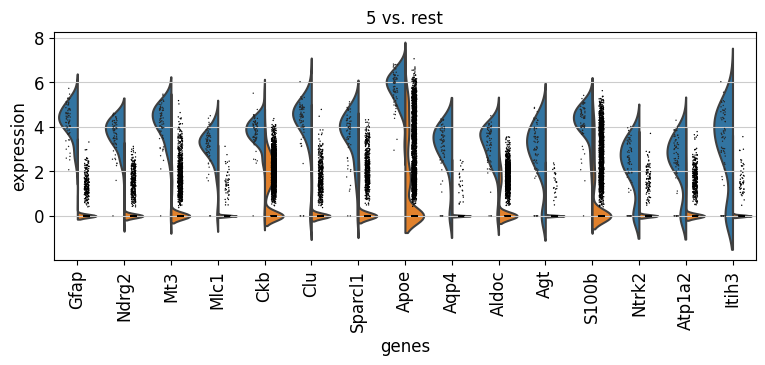

In [43]:
with rc_context({'figure.figsize': (9, 3)}):
    sc.pl.rank_genes_groups_violin(adata, n_genes=15, save= '_rank_genes_SC')

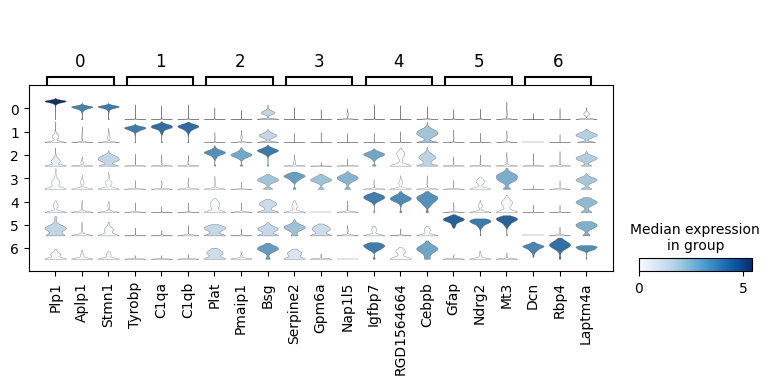

In [44]:
sc.pl.rank_genes_groups_tracksplot(adata, n_genes=3,dendrogram=False, save='rankGenes_SC')
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=3,dendrogram=False, save='rankGenes_violin_SC')

In [45]:
new_cluster_names = ['Oligodendrocytes', 'Microglia','Endothelial','Neurons','Fibroblast', 'Astrocytes', 'Other']
adata.obs['clusters'] = adata.obs['leiden_0.22']
adata.rename_categories('leiden_0.22', new_cluster_names)
adata.obs['cell_types']=adata.obs['leiden_0.22']

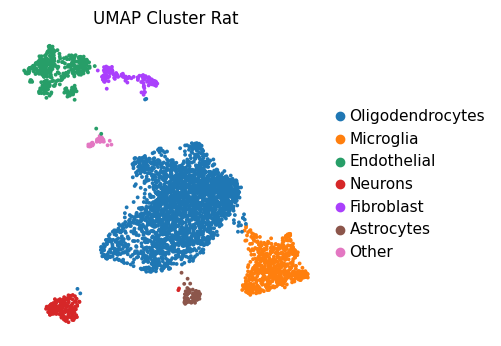

In [46]:
sc.pl.umap(adata, color='cell_types', legend_loc='right margin', title='UMAP Cluster Rat',frameon=False, save='UMAP_Rat2D_SC.pdf')
#sc.pl.umap(adata, color='leiden0.2', legend_loc='right margin', title='UMAP cluster Rat 3D',projection = '3d',frameon=False, save='.pdf')

In [47]:
adata

AnnData object with n_obs × n_vars = 3933 × 4242
    obs: 'sample', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_human', 'pct_counts_human', 'total_counts_rat', 'pct_counts_rat', 'species', 'leiden_0.22', 'clusters', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'human', 'rat', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Orig_VarNames', 'New_VarNames', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sample_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_0.22_sizes', 'leiden_0.22_colors', 'umap', 'clusters_colors', 'rank_genes_groups', 'cell_types_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

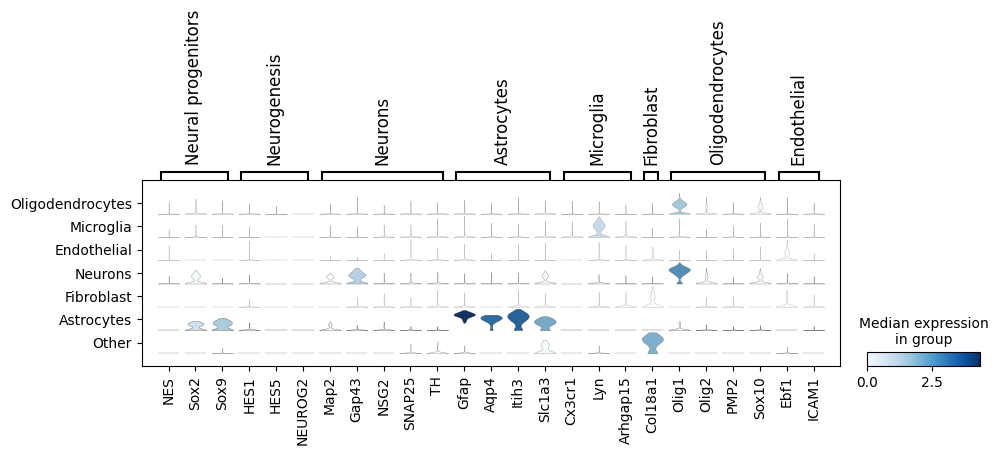

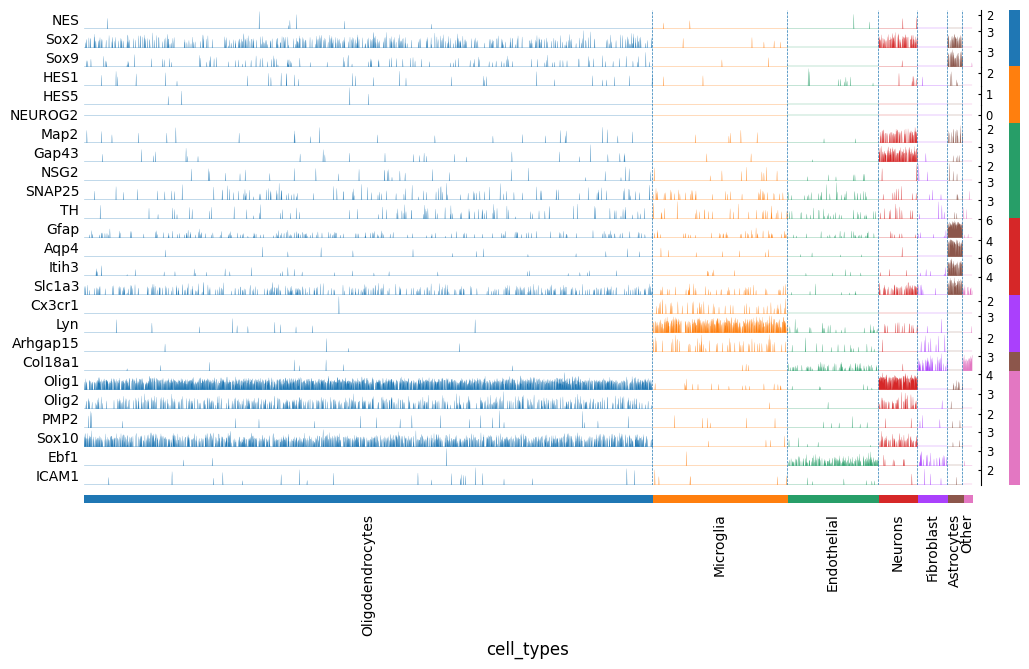

In [48]:
sc.pl.dotplot(adata, markerdict, groupby='cell_types', save='_CellMarker_SC')
sc.pl.stacked_violin(adata, markerdict, groupby='cell_types', rotation=90, save='_cellmarker_SC')
sc.pl.tracksplot(adata, markerdict, groupby='cell_types', dendrogram=False, save= 'Cellmarker_track_SC')

In [49]:
set(adata.obs['leiden_0.22'])

{'Astrocytes',
 'Endothelial',
 'Fibroblast',
 'Microglia',
 'Neurons',
 'Oligodendrocytes',
 'Other'}

In [50]:
adatapp.obs['cell_types']=adata.obs['leiden_0.22']

In [51]:
adatapp.obs.drop(adatapp.obs.columns.difference(['sample','cell_types']), 1, inplace=True)
adatapp.var.drop(adatapp.var.columns.difference(['gene_ids','Orig_VarNames']), 1, inplace=True)
del adatapp.obsm, adatapp.uns, adatapp.varm, adatapp.obsp

In [52]:
adatapp

AnnData object with n_obs × n_vars = 3933 × 4242
    obs: 'sample', 'cell_types'
    var: 'gene_ids', 'Orig_VarNames'

In [53]:
adata

AnnData object with n_obs × n_vars = 3933 × 4242
    obs: 'sample', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_human', 'pct_counts_human', 'total_counts_rat', 'pct_counts_rat', 'species', 'leiden_0.22', 'clusters', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'human', 'rat', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Orig_VarNames', 'New_VarNames', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sample_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_0.22_sizes', 'leiden_0.22_colors', 'umap', 'clusters_colors', 'rank_genes_groups', 'cell_types_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [54]:
adata.write(results_file)
adatapp.write(pp_file)